In [2]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import joblib


# fix random seed for reproducibility
np.random.seed(7)
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [3]:
def calculate_std(df): 
  prices = df['Close Price']
  returns = np.diff(prices) / prices[:-1]
  std_dev = np.std(returns)
  return std_dev

In [4]:
def calculate_std_deviation(df):
  prices = df['Close Price']
  returns = np.diff(prices) / prices[:-1]
  mean_return = np.mean(returns)
  deviations = [(ret - mean_return) ** 2 for ret in returns]
  variance = np.mean(deviations)
  volatility = np.sqrt(variance)
  return volatility

In [5]:
def realized_volatility(df, cut=0): 
  prices = df[cut:]['Close Price']
  returns = np.diff(np.log(prices)) * 100
  realized_volatility = np.sqrt(np.sum(returns ** 2))
  return realized_volatility

In [6]:
def historical_volatility(prices):
    returns = np.diff(np.log(prices[prices > 0])) * 100
    volatility = np.std(returns)
    return volatility


In [7]:
def read_and_prepare(path_name):
  path_name = './data/' + path_name + '.csv'
  df = pd.read_csv(path_name)
  df.columns = ['Open Time', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume', 'Close Time']
  # df['Open Time'] = pd.to_datetime(df['Open Time'] / 1000).dt.date
  # df['delta'] = (df['Open Time'] - df['Close Time']) / df['Close Time']
  return df

In [8]:
file_names = ['1minute', '3minute', '5minute', '15minute', '30minute', '1hour', '2hour', '4hour', '6hour', '8hour', '12hour', '1day', '1week', '1month']

In [9]:
dfs = []
for path in file_names:
  dfs.append(read_and_prepare(path))

In [10]:
stds = []
stds_by_time = []
cuts = [-10, -100, -200, -400, -1000, -2000, -5000, -10000, -20000]
index = 0
for df in dfs:
  df_cuts = []
  std = realized_volatility(df)
  stds.append(std)

  for cut in cuts:
    std = realized_volatility(df, cut)
    df_cuts.append(std)
  stds_by_time.append(df_cuts)


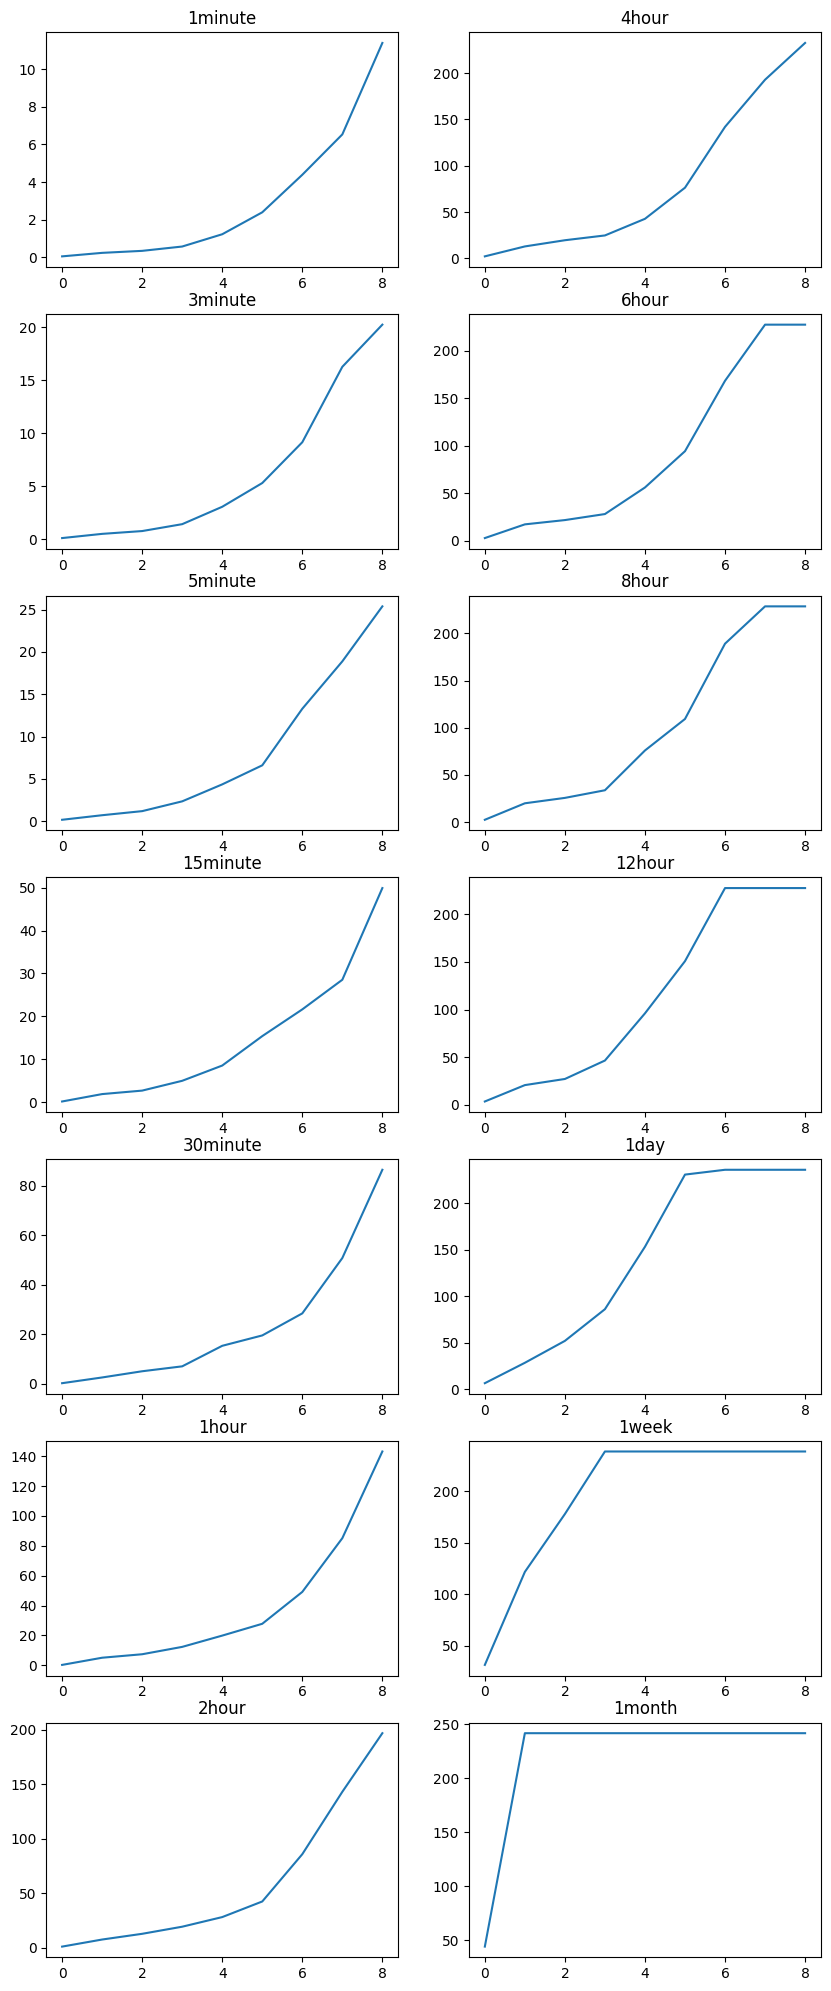

In [11]:
figure, axis = plt.subplots(7, 2, figsize=(10, 25))

for i in range(0, 7):
  for j in range(0, 2):
    axis[i, j].plot(stds_by_time[j * 7 + i])
    axis[i, j].set_title(file_names[j * 7 + i])


plt.show()


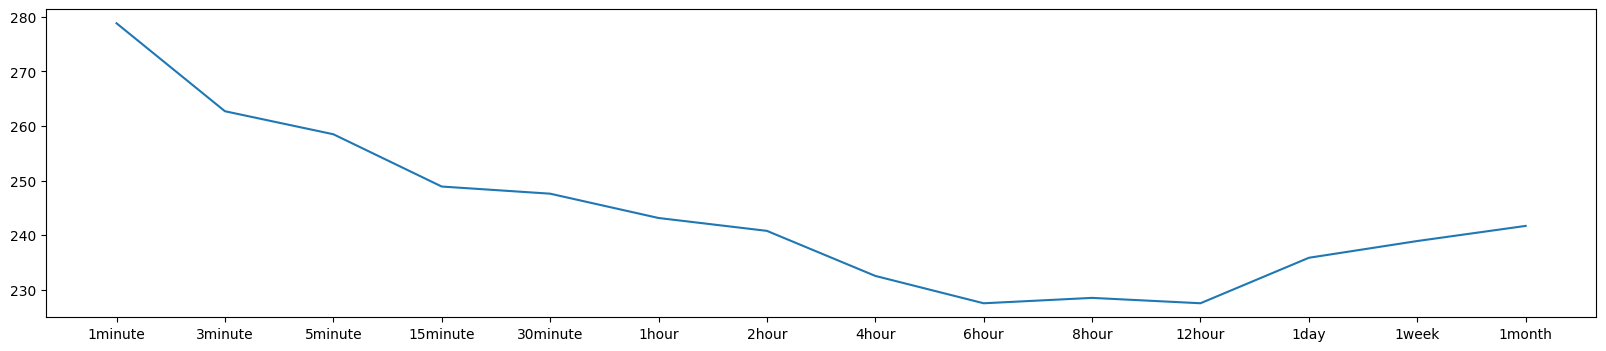

In [12]:
plt.figure(figsize=(20,4))
plt.plot(file_names, stds)
plt.show()

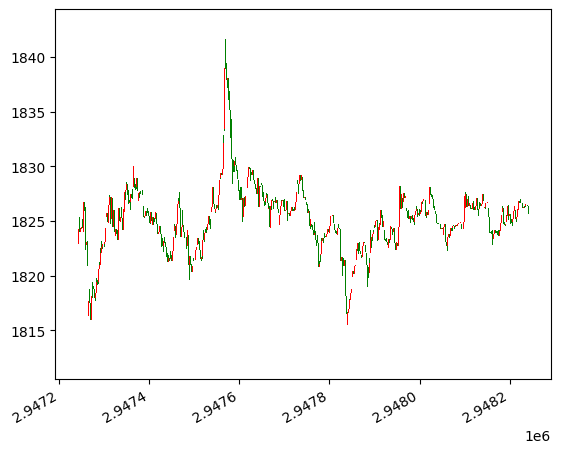

In [13]:
sliced_df = dfs[0][-1000:]

plt.figure()
  
up = sliced_df[sliced_df['Close Price'] >= sliced_df['Open Price']]
down = sliced_df[sliced_df['Close Price'] < sliced_df['Open Price']]
  
col1 = 'red'
col2 = 'green'
  
width = 2
width2 = .03
  
plt.bar(up.index, up['Close Price']-up['Open Price'], width, bottom=up['Open Price'], color=col1)
plt.bar(up.index, up['High Price']-up['Close Price'], width2, bottom=up['Close Price'], color=col1)
plt.bar(up.index, up['Low Price']-up['Open Price'], width2, bottom=up['Open Price'], color=col1)
  
# Plotting down prices of the stock
plt.bar(down.index, down['Close Price']-down['Open Price'], width, bottom=down['Open Price'], color=col2)
plt.bar(down.index, down['High Price']-down['Open Price'], width2, bottom=down['Open Price'], color=col2)
plt.bar(down.index, down['Low Price']-down['Close Price'], width2, bottom=down['Close Price'], color=col2)
  
# rotating the x-axis tick labels at 30degree 
# towards right
plt.xticks(rotation=30, ha='right')
  
# displaying candlestick chart of stock data 
# of a week
plt.show()

In [14]:
dataset = dfs[0]['Close Price'][-1000:].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
dataset[:10]

array([[1823.73],
       [1824.26],
       [1825.34],
       [1824.19],
       [1823.96],
       [1824.41],
       [1824.24],
       [1824.25],
       [1824.49],
       [1825.23]], dtype=float32)

In [15]:
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

670 330


In [22]:
# reshape into X=t and Y=t+1
look_back = 50
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
619/619 - 2s - loss: 0.0119 - 2s/epoch - 4ms/step
Epoch 2/200
619/619 - 2s - loss: 0.0033 - 2s/epoch - 3ms/step
Epoch 3/200
619/619 - 2s - loss: 0.0024 - 2s/epoch - 3ms/step
Epoch 4/200
619/619 - 2s - loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 5/200
619/619 - 2s - loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 6/200
619/619 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 7/200
619/619 - 2s - loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 8/200
619/619 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 9/200
619/619 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 10/200
619/619 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 11/200
619/619 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 12/200
619/619 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 13/200
619/619 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 14/200
619/619 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 15/200
619/619 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 16/200
619/619 - 2s - loss: 0.0010 - 2s/epoch - 3ms/step
E

KeyboardInterrupt: 

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

9/9 [==============================] - 0s 1ms/step
Train Score: 0.03 RMSE
Test Score: 0.02 RMSE


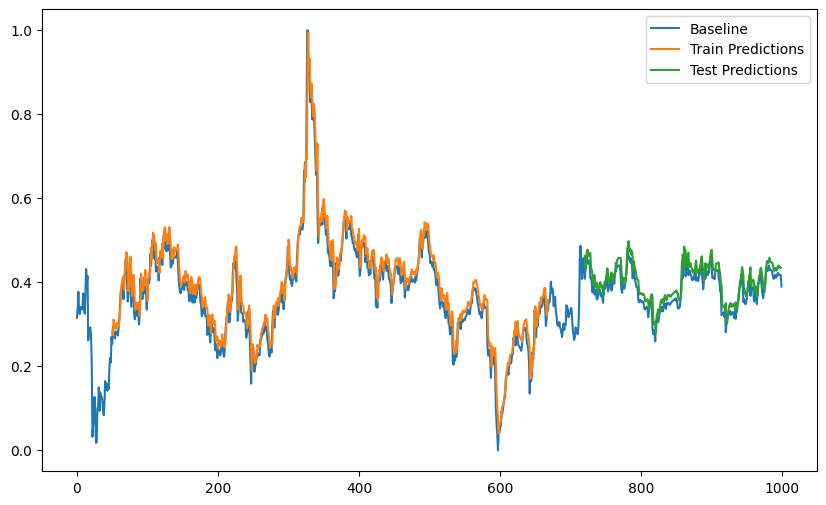

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label='Baseline')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()  # Add legend
plt.show()
